# Klasteryzacja (Enron mails) Przemysław Robak

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import email
from sklearn.cluster import KMeans 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from scipy.stats import multivariate_normal as mvn
import nltk
import os
import random
import re

### Wczytanie danych do dataframe'u

In [2]:
df = pd.read_csv(r'C:\Users\Przem\Desktop\emails.csv')

In [3]:
df.head()

,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


In [4]:
df.shape

(517401, 2)

### Wyświetlenie przykładowego mail'a

In [5]:
print(df.loc[1]['message'])

Message-ID: <15464986.1075855378456.JavaMail.evans@thyme>
Date: Fri, 4 May 2001 13:51:00 -0700 (PDT)
From: phillip.allen@enron.com
To: john.lavorato@enron.com
Subject: Re:
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: John J Lavorato <John J Lavorato/ENRON@enronXgate@ENRON>
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail
X-Origin: Allen-P
X-FileName: pallen (Non-Privileged).pst

Traveling to have a business meeting takes the fun out of the trip.  Especially if you have to prepare a presentation.  I would suggest holding the business plan meetings here then take a trip without any formal business meetings.  I would even try and get some honest opinions on whether a trip is even desired or necessary.

As far as the business meetings, I think it would be more productive to try and stimulate discussions across the different groups about what is working and what is not.  Too often the

### Utworzenie kolumn _body_ i _user_ , zawierających odpowiednio treść wiadomości, oraz nadawcę wiadomości

In [6]:
emails = list(map(email.parser.Parser().parsestr,df['message']))
    
def get_raw_text(emails):
    email_text = []
    for email in emails.walk():
        if email.get_content_type() == 'text/plain':
            email_text.append(email.get_payload())
    return ''.join(email_text)

df['body'] = list(map(get_raw_text, emails))

df['user'] = df['file'].map(lambda x: x.split('/')[0])

In [7]:
df.head()

,file,message,body,user
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,Here is our forecast\n\n,allen-p
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,Traveling to have a business meeting takes the...,allen-p
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,test successful. way to go!!!,allen-p
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,"Randy,\n\n Can you send me a schedule of the s...",allen-p
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,Let's shoot for Tuesday at 11:45.,allen-p


### Czyszczenie tekstu

In [8]:
def clean_column(data):
    if data is not None:
        stopwords_list = stopwords.words('english')
        data =  data.lower()
        data = re.sub('re:', '', data)
        data = re.sub('-', '', data)
        data = re.sub('_', '', data)
        data =re.sub('\[[^]]*\]', '', data)
        data = re.sub(r'[^\w\s]','',data)
        data = re.sub(r'\n',' ',data)
        data = re.sub(r'[0-9]+','',data)
        p = re.compile(r'<.*?>')
        data = re.sub(r"\'ve", " have ", data)
        data = re.sub(r"can't", "cannot ", data)
        data = re.sub(r"n't", " not ", data)
        data = re.sub(r"I'm", "I am", data)
        data = re.sub(r" m ", " am ", data)
        data = re.sub(r"\'re", " are ", data)
        data = re.sub(r"\'d", " would ", data)
        data = re.sub(r"\'ll", " will ", data)
        data = re.sub('forwarded by phillip k allenhouect on    pm', '',data)
        data = re.sub(r"httpitcappscorpenroncomsrrsauthemaillinkaspidpage", "", data)
        
        data = p.sub('', data)
        if 'forwarded by:' in data:
            data = data.split('subject')[1]
        data = data.strip()
        return data
    return 'No Subject'

In [9]:
df['body_new'] = df['body'].apply(clean_column)

In [10]:
df.head()

,file,message,body,user,body_new
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,Here is our forecast\n\n,allen-p,here is our forecast
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,Traveling to have a business meeting takes the...,allen-p,traveling to have a business meeting takes the...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,test successful. way to go!!!,allen-p,test successful way to go
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,"Randy,\n\n Can you send me a schedule of the s...",allen-p,randy can you send me a schedule of the sala...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,Let's shoot for Tuesday at 11:45.,allen-p,lets shoot for tuesday at


### WorkCloud - Wizualizacja najczęściej występujących słów

In [11]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
to_add = ['FW', 'ga', 'httpitcappscorpenroncomsrrsauthemaillinkaspidpage', 'cc', 'aa', 'aaa', 'aaaa',
         'hou', 'cc', 'etc', 'subject', 'pm', 'ect', 'com', 'recipient']

for i in to_add:
    stopwords.add(i)

In [12]:
wordcloud = WordCloud(
                          collocations = False,
                          width=1600, height=800,
                          background_color='white',
                          stopwords=stopwords,
                          max_words=150,
                          #max_font_size=40, 
                          random_state=42
                         ).generate(' '.join(df['body_new']))

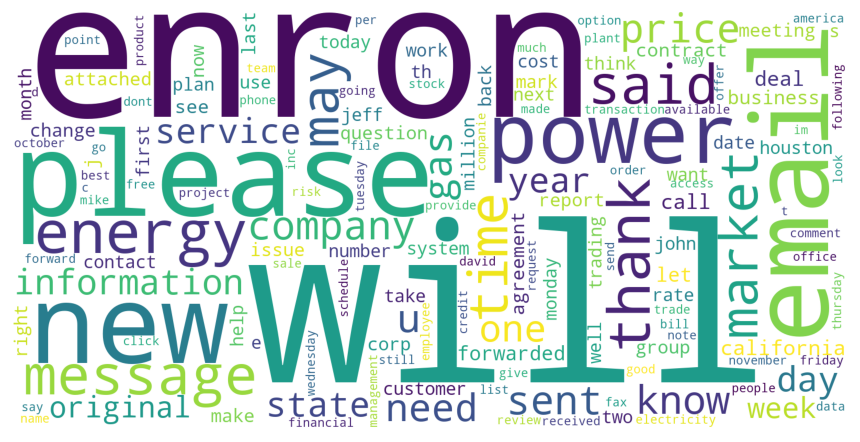

In [13]:
plt.figure(figsize=(9,8), dpi=120)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Transformacja danych do modelu klasteryzacji

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
data = df['body_new']
tf_idf_vectorizor = TfidfVectorizer(stop_words = stopwords,#tokenizer = tokenize_and_stem,
                             max_features = 1200)
tf_idf = tf_idf_vectorizor.fit_transform(data)
tf_idf_norm = normalize(tf_idf)

C:\Users\Przem\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'fw', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


In [15]:
tf_idf_array = tf_idf_norm.toarray()

In [16]:
pd.DataFrame(tf_idf_array, columns=tf_idf_vectorizor.get_feature_names()).head(20)

C:\Users\Przem\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,ability,able,access,according,account,accounting,across,act,action,...,wr,written,yahoo,year,years,yes,yesterday,yet,york,youre
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.128890,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0
5,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0
6,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0
7,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0
8,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0
9,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.069541,0.0,0.0,...,0.0,0.0,0.0,0.09915,0.055993,0.0,0.0,0.000000,0.0,0.0


### Redukacja liczby zmiennych za pomoca PCA

In [17]:
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)

### Wybór liczby klastrów za pomocą metdoy łokcia

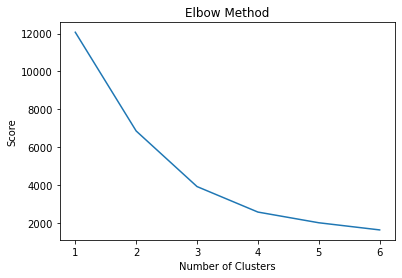

In [18]:
number_clusters = range(1, 7)

kmeans = [KMeans(n_clusters=i) for i in number_clusters]
kmeans

score = [kmeans[i].fit(Y_sklearn).score(Y_sklearn) for i in range(len(kmeans))]
score = [i*-1 for i in score]

plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

### Klasteryzacja z 3 klastramia, z wykorzystaniem algorytmu K-Means

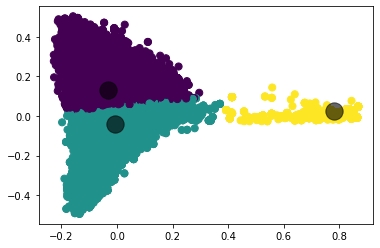

In [30]:
kmeans = KMeans(n_clusters= 3)
fitted = kmeans.fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)

plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1],c=prediction ,s=50, cmap='viridis')

centers2 = fitted.cluster_centers_
plt.scatter(centers2[:, 0], centers2[:, 1],c='black', s=300, alpha=0.6)
plt.show()

### Wykresy najważniejszych słów w klastrach

In [31]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = tf_idf_vectorizor.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs
dfs = get_top_features_cluster(tf_idf_array, prediction, 20)

C:\Users\Przem\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


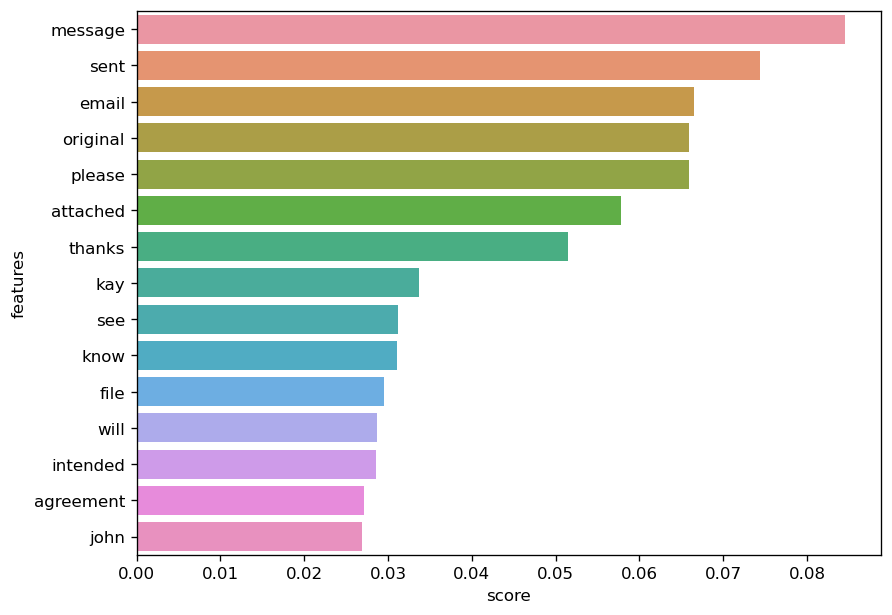

In [33]:
plt.figure(figsize=(8,6), dpi=120)
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[0][:15])
plt.show()

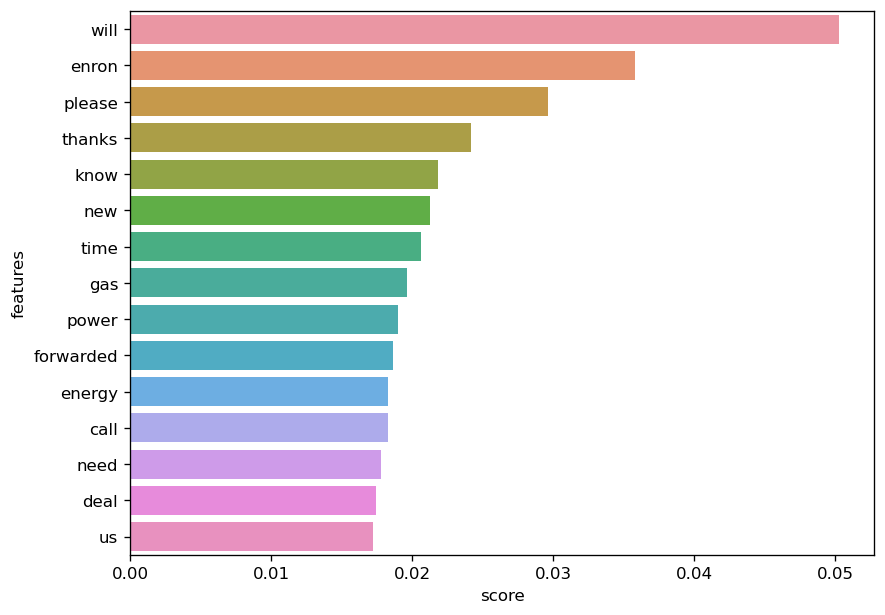

In [34]:
plt.figure(figsize=(8,6), dpi=120)
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[1][:15])
plt.show()

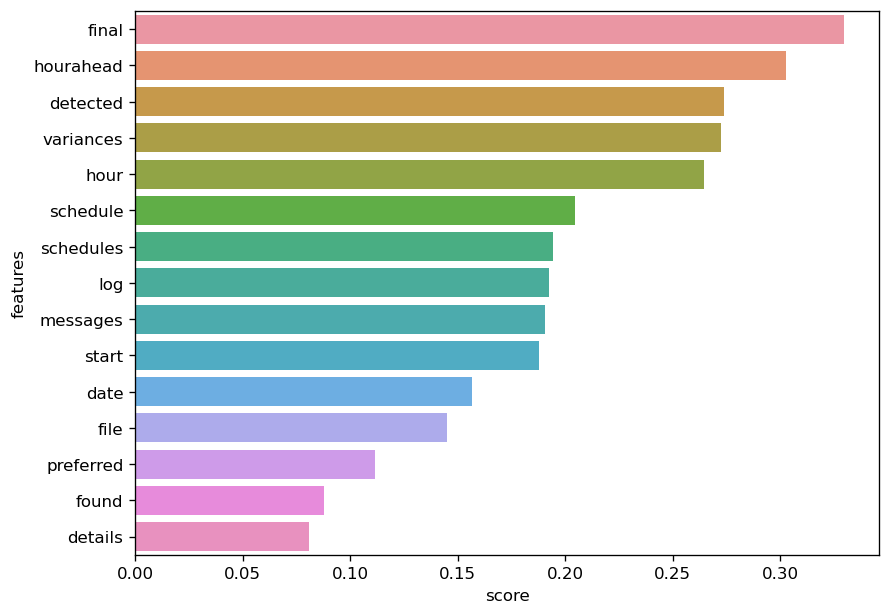

In [35]:
plt.figure(figsize=(8,6), dpi=120)
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[2][:15])
plt.show()

C:\Users\Przem\AppData\Local\Temp/ipykernel_6708/2995603474.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  yticks = ax.set_yticklabels(df.features)


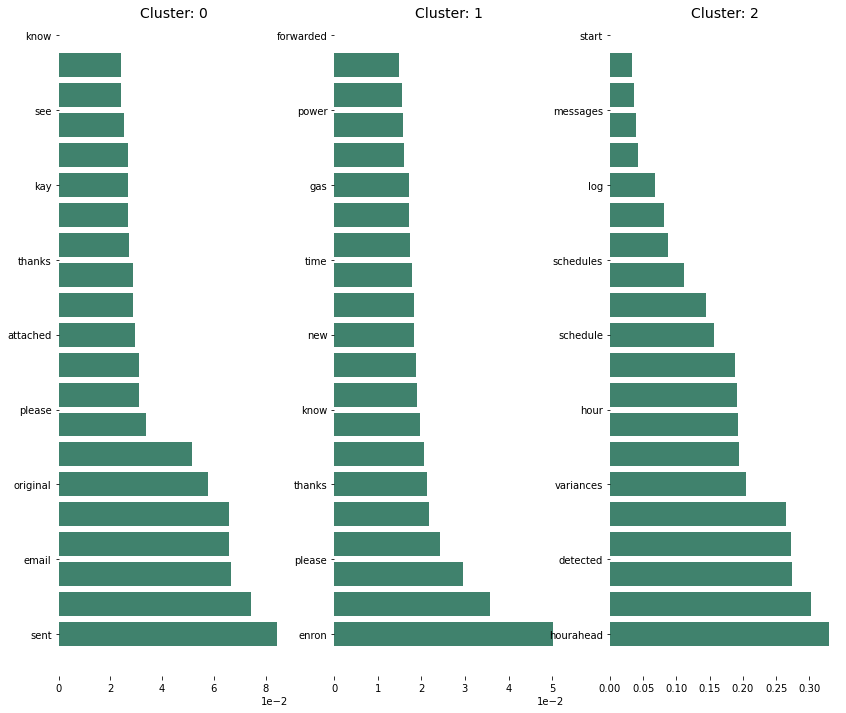

In [36]:
def plot_features(dfs):
    fig = plt.figure(figsize=(14,12))
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.set_title("Cluster: "+ str(i), fontsize = 14)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.score, align='center', color='#40826d')
        yticks = ax.set_yticklabels(df.features)
    plt.show();
plot_features(dfs)